# PyTerrier ECIR 2021 Tutorial Notebook - Part 2

This notebook provides experiences to attendees for building transformer pipelines in [PyTerrier](https://github.com/terrier-org/pyterrier). All experiments are conducted using the [CORD19 corpus](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7251955/) and the [TREC Covid test collection](https://ir.nist.gov/covidSubmit/).

This notebook is divided in two, following the structure of the slides. In particular, in Part 2A you will experience: 
 - understand the PyTerrier data model;
 - understand the general notion of PyTerrier transformers and operators for combining transformers into new transformers;
 - undertake experiments on the TREC Covid test collection.

In Part 2B, you will experience:
 - construct and learn learning-to-rank pipelines;
 - evaluate and analyse learning-to-rank pipelines.


# Setup

We install PyTerrier, as well as the [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [FastRank](https://github.com/jjfiv/fastrank) learning-to-rank implementations, and we will initialise PyTerrier.

In [ ]:
!pip install --upgrade fastrank lightgbm==3.1.1
!pip install python-terrier

     |████████████████████████████████| 891 kB 12.1 MB/s 
     |████████████████████████████████| 1.8 MB 62.8 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 97 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 19.2 MB/s 
     |████████████████████████████████| 69 kB 6.6 MB/s 
     |████████████████████████████████| 297 kB 44.6 MB/s 
     |████████████████████████████████| 41 kB 224 kB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 294 kB 78.4 MB/s 
     |████████████████████████████████| 1.2 MB 81.1 MB/s 
     |████████████████████████████████| 126 kB 79.7 MB/s 
     |████████████████████████████████| 596 kB 69.6 MB/s 
     |████████████████████

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)

[INFO] trec-robust04 is deprecated. Consider using disks45/nocr/trec-robust-2004 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold1 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold1 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold2 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold2 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold3 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold3 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold4 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold4 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold5 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold5 instead, which provides better parsing of the corpus.


# Indexing

We're going to create a new index for Cord19. In this index, we use the `blocks=True` argument, so that we have position information in the index.
Indexing takes ~1 minute.

In [ ]:
import os

cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './terrier_cord19_blocks'

if not os.path.exists(pt_index_path + "/data.properties"):
    # create the index, using the IterDictIndexer indexer 
    indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    index_ref = indexer.index(cord19.get_corpus_iter(), 
                              fields=('abstract',), 
                              meta=('docno',))

else:
    # if you already have the index, use it.
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")

index = pt.IndexFactory.of(index_ref)

[INFO] [starting] building docstore
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
docs_iter:   0%|                                    | 0/192509 [00:00<?, ?doc/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 0.00/269M [00:00<?, ?B/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 24.6k/269M [00:00<27:40, 162kB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 57.3k/269M [00:00<24:39, 182kB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 106k/269M [00:00<20:04, 223kB/s] 
https://ai2-semanticscholar-cord-1

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  


19:34:30.541 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
19:35:36.473 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 54937 empty documents
19:35:37.518 [ForkJoinPool-1-worker-3] ERROR org.terrier.structures.indexing.Indexer - Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BlockIndexer.createDirectIndex(BlockIndexer.java:472)
	at org.terrier.structures.indexing

## Transformers & Operators

You'll have noted that BatchRetrieve has a `transform()` method that takes as input a dataframe, and returns another dataframe, which is somehow a *transformation* of the earlier dataframe (e.g., a retrieval transformation). In fact, `BatchRetrieve` is just one of many similar objects in PyTerrier, which we call [transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html) (represented by the `TransformerBase` class).

Let's give a look at a `BatchRetrieve` transformer, starting with one for the TF_IDF weighting model.

In [ ]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

# check tfidf is a transformer...
print(isinstance(tfidf, pt.transformer.TransformerBase))

True


In [ ]:
# this prints the type hierarchy of the TF_IDF class
tfidf.__class__.__mro__

(pyterrier.batchretrieve.BatchRetrieve,
 pyterrier.batchretrieve.BatchRetrieveBase,
 pyterrier.transformer.TransformerBase,
 pyterrier.transformer.Transformer,
 matchpy.expressions.expressions.Symbol,
 matchpy.expressions.expressions.Atom,
 matchpy.expressions.expressions.Expression,
 object)

The interesting capability of all transformers is that they can be combined using Python operators (this is called *operator overloading*).

Concretely, imagine that you want to chain transformers together – e.g. rank documents first by Tf then re-ranked the *exact same* documents by TF_IDF. We can do this using the `>>` operator – we call this *composition*, or "*then*".

In [ ]:
# this is our first retrieval transformer
# it transform a queries dataframe to a results dataframe
tf = pt.BatchRetrieve(index, wmodel="Tf")

tf( cord19.get_topics(variant='title').head(1) )

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [9.06MB/s]
/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,qid,docid,docno,rank,score,query
0,1,146967,jkrj0lbm,0,25.0,coronavirus origin
1,1,25564,jlzncyax,1,18.0,coronavirus origin
2,1,45549,8l411r1w,2,15.0,coronavirus origin
3,1,29359,gnxbfcod,3,14.0,coronavirus origin
4,1,63537,cpc6v40g,4,14.0,coronavirus origin
...,...,...,...,...,...,...
995,1,58583,wfcyaumm,995,4.0,coronavirus origin
996,1,59153,86vu0kjm,996,4.0,coronavirus origin
997,1,59343,9n733bet,997,4.0,coronavirus origin
998,1,59478,mx58ai55,998,4.0,coronavirus origin


In [ ]:
# now let's define a pipeline 
pipeline = tf >> tfidf
print(isinstance(tfidf, pt.transformer.TransformerBase))

pipeline( cord19.get_topics(variant='title').head(1) )

True


/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,qid,docid,docno,rank,score,query
0,1,175892,zy8qjaai,0,7.080599,coronavirus origin
1,1,82224,8ccl9aui,1,6.775667,coronavirus origin
2,1,135326,ne5r4d4b,2,6.683114,coronavirus origin
3,1,93245,hmvo5b0q,3,6.507303,coronavirus origin
4,1,84953,ax6v6ham,4,6.483723,coronavirus origin
...,...,...,...,...,...,...
995,1,136214,ygnxmcl1,995,1.640752,coronavirus origin
996,1,91270,853ipgea,996,1.634118,coronavirus origin
997,1,146556,oshov14d,997,1.634118,coronavirus origin
998,1,32462,xtfjw1ag,998,1.592462,coronavirus origin


There are a number of PyTerrier operators – there are more examples in the [PyTerrier documentation on operators](https://pyterrier.readthedocs.io/en/latest/operators.html)

## Practice Task – Pipeline Construction

Create a ranker that performs the follinwg:
 - obtains the top 10 highest scoring documents by term frequency (`wmodel="Tf"`)
 - obtains the top 10 highest scoring documents by TF.IDF (`wmodel="TF_IDF"`)
 - reranks only those documents found in BOTH of the previous retrieval settings using BM25.

How many documents are retrieved by this full pipeline for the query `"chemical"`.
> If you obtain the correct solution, the document with docno `"37771"` should have a score of $12.426309	$ for query `"chemical"`.

Hints:
 - choose careully your [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - you should not need to perform any Pandas dataframe operations

In [ ]:
# SOLUTION GOES HERE
tf_br = pt.BatchRetrieve(index, wmodel="Tf", num_results=10)
tf_idf_br = pt.BatchRetrieve(index, wmodel="TF_IDF", num_results=10)
intersection = (tf_br & tf_idf_br)
reranked = intersection >> pt.BatchRetrieve(index, wmodel="BM25")
reranked.search("chemical")



,qid,docid,docno,rank,score,query
0,1,37771,jn5qi1jb,0,12.426309,chemical
1,1,134305,0smev8vt,1,12.292890,chemical
2,1,142104,77c9ohxj,2,12.226076,chemical
3,1,56631,sps45fj5,3,11.642770,chemical
4,1,2524,ifebw24e,4,11.439890,chemical


## Other transformers in the toolbox

Lets start creating more interesting retrieval pipelines. We'll define these, but firstly lets recap on the PyTerrier datamodel:
 - $Q$: a set of queries
 - $D$: a set of documents
 - $R$: a set of retrieved documents for a set of queries

Lets use three: 
 - `pt.BatchRetrieve(index, wmodel="BM25")` - input $Q$ or $R$ (retrieval or reranking), output $R$
 - `pt.rewrite.SDM()` (sequential dependence proximity model) - input $Q$, output $Q$. 
 - `pt.rewrite.Bo1QueryExpansion(index)` - input $R$, output $Q$.




In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

Lets see how `sdm` applies to a given query. This generates a query in an Indri-like query language that Terrier (c.f. `pt.BatchRetrieve()`) can understand.
 - `#combine()` - is used for weighting sub-expressions
 - `#1() - matches as a phrase, i.e. how many times does the constituent words exactly match as a phrase
 - `#uw8()` and `#uw12()` look for how many times the constituent words appear in unordered windows of 8 or 12 tokens.
 - finally, the weighting model is overridden for these query terms.
  

In [ ]:
sdm.search("chemical reactions").iloc[0]["query"]

'chemical reactions #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#1(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw8(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw12(chemical reactions))'

## Practice Task – Experimenting with Pipelines

Conduct an [Experiment](https://pyterrier.readthedocs.io/en/latest/experiments.html) comparing sequential dependence model and Bo1 query expansion on TREC CORD19 with the BM25 baseline. You will need to construct appropriate pipelines, by considering the input and output datatypes of the `bm25`, `sdm` and `qe`. 

Which approaches result in significant increases in NDCG and MAP? Is NDCG@10 also improved?

In [ ]:
topics = cord19.get_topics(variant='title')
qrels = cord19.get_qrels()

/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)
[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:24] [1.14MB] [46.9kB/s]


In [ ]:
# SOLUTION GOES HERE
pt.Experiment(
    [bm25, bm25 >> qe >> bm25, sdm >> bm25],
    topics,
    qrels,
    eval_metrics=[pt.measures.MAP, pt.measures.nDCG, pt.measures.nDCG@10],
    baseline=0,
    names=["bm25", "bm25 -> QE -> bm25", "sdm -> bm25"]
)


,name,AP,nDCG,nDCG@10,AP +,AP -,AP p-value,nDCG +,nDCG -,nDCG p-value,nDCG@10 +,nDCG@10 -,nDCG@10 p-value
0,bm25,0.181478,0.373328,0.583665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bm25 -> QE -> bm25,0.190398,0.388397,0.580906,39.0,11.0,0.014744,35.0,15.0,0.000278,22.0,24.0,0.841969
2,sdm -> bm25,0.181982,0.373439,0.586512,31.0,19.0,0.005959,28.0,22.0,0.724088,11.0,13.0,0.579152


# Part 2B – Learning to Rank

In this part of the notebook, you will experience constructing, learning, evaluating and analysing learning to rank pipelines.


Firstly, lets split out topics into train, validation and test sets. TREC Covid only has 50 topics, which isnt a lot for training(!). We'll split this 30 for training 5 for validation and 15 for evaluation. We will also examine statistical significance, even if this is artificial for 15 topics.

We're only going to-rank the top 10 documents for each query - hopefully learning to rank can help to re-rank the top 10 documents to be more effective.

In [ ]:
RANK_CUTOFF = 10
SEED=42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=15, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=5, random_state=SEED)

## Feature Set

Lets define our feature set.  We're going to have a total of 7 features:

1.   the BM25 abstract score;
2.   sequential dependence model, scored by BM25;
3.   does the abstract contain 'coronavirus covid', scored by BM25;
4.   the BM25 score on the title (even though we didnt index it earlier!);
5.   was the paper released/published in 2020? Recent papers were more useful for this task;
6.   does the paper have a DOI, i.e. is it a formal publication?
7.   the coordinate match score for the query - i.e. how many query terms appear in the abstract.

Several of these feature require additional metadata `["title", "date", "doi"]`. Fortunately, the TREC Covid dataset allows us to obtain more metadata after indexing. We use `pt.text.get_text(cord19, ["title", "date", "doi"])` to retrieve these extra metadata columns.


In [ ]:
ltr_feats1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25') ) 
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0) ))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

# for reference, lets record the feature names here too
fnames=["BM25", "SDM", 'coronavirus covid', 'title', "2020", "hasDoi", "CoordinateMatch"]

Lets see the output for a particular query. We can see that we now have extra document metadata columns `["title", "date", "doi"]`, as well as the all-important `"features"` columns. This makes dataframe have type $R_f$. Indeed,  it is this column that we use for learning.

In [ ]:
ltr_feats1.search("coronovirus origin")

21:43:24.121 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,rank,score,query,title,date,doi,features
0,1,188321,8bn74f2z,0,20.541477,coronovirus origin,Reply to Comments on 'Co‐infection of SARS‐CoV...,2020-04-08,10.1002/jmv.25838,"[20.541476673741375, 20.541476673741375, 2.899..."
1,1,93090,ciqs6l7e,1,19.859401,coronovirus origin,The spread of the COVID-19 coronavirus: Health...,2020,,"[19.859401180444888, 19.859401180444888, 2.803..."
2,1,93091,qe9w4qbu,2,19.859401,coronovirus origin,The spread of the COVID-19 coronavirus: Health...,2020,,"[19.859401180444888, 19.859401180444888, 2.803..."
3,1,152453,egzztatj,3,19.459604,coronovirus origin,The spread of the COVID‐19 coronavirus: Health...,2020-03-17,10.15252/embr.202050334,"[19.459604473560834, 19.459604473560834, 2.747..."
4,1,105298,9ci1u50r,4,18.009391,coronovirus origin,Placental Pathology in Covid-19 Positive Mothe...,2020,,"[18.009390548413062, 18.009390548413062, 0.0, ..."
5,1,175511,kdo2hir8,5,18.009391,coronovirus origin,Placental Pathology in Covid-19 Positive Mothe...,2020-05-12,10.1177/1093526620925569,"[18.009390548413062, 18.009390548413062, 0.0, ..."
6,1,97984,76laky91,6,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
7,1,97985,niytf3wo,7,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
8,1,97986,262bcl7h,8,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
9,1,97987,nip1ax1x,9,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."


We can also look at the raw features values (in this case for the first ranked document). Note that the BM25 in the "score" column above is also the first value in the feature array (20.54), because we used an identity transformer.

In [ ]:
ltr_feats1.search("coronovirus origin").iloc[0]["features"]

21:44:12.282 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


array([20.54147667, 20.54147667,  2.89976767,  0.        ,  1.        ,
        1.        ,  1.        ])

## Learning 

In this part of the the notebook, we apply three different learning to rank techniques:

 - coordinate ascent from FastRank, a listwise linear technique
 - random forests from `scikit-learn`, a pointwise regression tree technique
 - LambdaMART from LightGBM, a listwise regression tree technique

In each case, we take our feature pipeline, `ltr_feats1`, and we compose it (`>>`) with the learned model. We use `pt.ltr.apply_learned_model()` which knows how to deal with different learners.

The full pipeline is then fitted (learned) using `.fit()`, specifying the training topics and qrels. Importantly, the preceeding stages of the pipeline (retrieval and feature calculation) are applied to the training topics in order to obtained the results, which are then passed to the learning to rank technique. LightGBM has early stopping enabled, which uses a validation topics set – similarly the validation topics are transformed into validation results.

Finally, `%time` is notebook "magic command" which displays how long learning takes for each technique. Learning for each technique takes < 30 seconds.

In [ ]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, cord19.get_qrels())

21:44:31.525 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:774: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7ff289dede90>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  results = m.transform(inputRes.copy())


CPU times: user 1min 39s, sys: 1.23 s, total: 1min 40s
Wall time: 59.7 s


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, cord19.get_qrels())

21:45:44.309 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:774: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7ff289dede90>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  results = m.transform(inputRes.copy())
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.0s


CPU times: user 17.4 s, sys: 618 ms, total: 18 s
Wall time: 12.5 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    6.0s finished


In [ ]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe.fit(train_topics, cord19.get_qrels(), valid_topics, cord19.get_qrels())

21:46:04.202 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:790: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7ff289dede90>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  "missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


21:46:06.887 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:790: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7ff289dede90>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  "missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 65832, number of used features: 7
[Li

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


## Evaluation

Lets now compare our ranking pipelines on our 15 topics with the BM25 baseline. In all cases, we're ranking only 10 results per query, so MAP will be lower. 

We'll report mean response time (`"mrt"`) as well as MAP, NDCG and NDCG@10 measures.

In [ ]:
pt.Experiment(
    [bm25 % RANK_CUTOFF, ca_pipe, rf_pipe, lmart_x_pipe],
    test_topics,
    qrels, 
    names=["BM25",  "BM25 + CA(7f)", "BM25 + RF(7f)", "BM25 + LMart(7f)"],
    baseline=0,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"])

21:46:22.929 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:46:24.924 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


21:46:27.223 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg,ndcg_cut_10,mrt,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BM25,0.010480,0.043844,0.537236,55.900148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 + CA(7f),0.012273,0.049318,0.583883,129.595466,9.0,3.0,0.031714,10.0,4.0,0.062297,10.0,4.0,0.089405
2,BM25 + RF(7f),0.011271,0.045830,0.551404,149.629041,8.0,3.0,0.216817,9.0,4.0,0.233364,9.0,4.0,0.420787
3,BM25 + LMart(7f),0.009926,0.042458,0.528034,155.455234,5.0,7.0,0.322366,7.0,7.0,0.503059,7.0,7.0,0.604548


Thats really interesting – all three learned models could improve NDCG@10 over BM25, but the coordinate ascent model improved the most (significantly so on all three metrics, but again on only 15 queries). Coordinate Ascent improved upto 10 queries.

## Analysis

Lets start to analyse our learned models. Two things we could do is either a feature ablation study, or to evaluate the performance of each feature independently. To to that, we compose the feature pipeline (`ltr_feats1`) with `pt.ltr.feature_to_score(i)` for some feature number $i$.

In [ ]:
pt.Experiment(
    [ltr_feats1 >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "num_rel_ret"])

21:46:48.662 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:46:50.703 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:46:53.034 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:46:55.098 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,name,map,ndcg,ndcg_cut_10,num_rel_ret
0,BM25,0.010480,0.043844,0.537236,95.0
1,SDM,0.010429,0.043568,0.535770,95.0
2,coronavirus covid,0.011637,0.046777,0.562223,95.0
3,title,0.011799,0.047354,0.567363,95.0
4,2020,0.011064,0.045604,0.555846,95.0
5,hasDoi,0.009928,0.042970,0.531974,95.0
6,CoordinateMatch,0.010742,0.044333,0.540893,95.0


Interesting, we observe that the 'coronavirus covid' feature achieved NDCG@10 of 0.572172. On average, this outperforms some of the regression tree-based learners. That coordinate ascent could outperform the strongest feature gives some credence to the appropriateness of such a linear learner in  environments without lots of training data.

Next, we analyse the actual learned models. For the coordinate ascent model, we plot the feature weights (note the log-scale y-axis); while for the regression-tree based techniques, we report the feature importance.

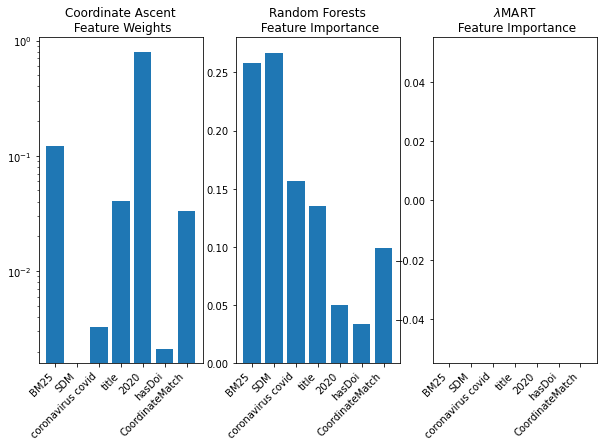

In [ ]:
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()


## Practice Task – Concatenation

Our learned model has low recall because only 10 documents are re-ranked. Lets make a small function, `append_baseline()`, that can append the BM25 baselines results to the output of the learned model. This is defined using [transformer operators](https://pyterrier.readthedocs.io/en/latest/operators.html) (`^` and `%`).

As an exercise, apply `append_baseline()` to each of the learned model pipelines defined above, and report the MAP and NDCG computed on all 1000 ranked results. 

Which of the learned models result in significantly improved MAP and NDCG?


In [ ]:
def append_baseline(system, baseline, max_results = 1000):
    return (system ^ baseline) % max_results

In [ ]:
#SOLUTION GOES HERE

pt.Experiment(
    [bm25] + [append_baseline(i, bm25) for i in [ca_pipe, rf_pipe, lmart_x_pipe]],
    test_topics,
    qrels,
    names=["BM25",  "BM25 + CA(7f)", "BM25 + RF(7f)", "BM25 + LMart(7f)"],
    baseline=0,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"],
)

22:06:53.405 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:06:56.305 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


22:06:59.604 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg,ndcg_cut_10,mrt,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BM25,0.128766,0.311467,0.537061,38.516845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 + CA(7f),0.130567,0.316955,0.583883,206.097041,9.0,3.0,0.030635,10.0,4.0,0.061306,10.0,4.0,0.087281
2,BM25 + RF(7f),0.129565,0.313467,0.551404,210.974948,8.0,3.0,0.211130,9.0,4.0,0.228643,9.0,4.0,0.412089
3,BM25 + LMart(7f),0.128220,0.310096,0.528034,189.184472,5.0,7.0,0.328540,7.0,7.0,0.507269,7.0,7.0,0.610619


#  That's all folks

If you arent coming back to Part 3 of the tutorial, please dont forget to complete our exit quiz: https://forms.office.com/r/2WbpLiQmWV